# Feature Selection



In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel
from bartpy.featureselection import SelectNullDistributionThreshold, SelectSplitProportionThreshold
from bartpy.diagnostics.features import *

%matplotlib inline

Text(0.5,1,'X v y')

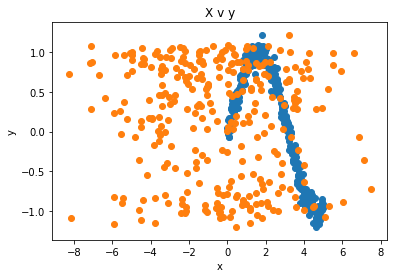

In [3]:
x = np.linspace(0, 5, 300)
X = np.random.normal(0, 3, size = 300 * 2).reshape(300, 2)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=300) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [4]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=20, store_in_sample_predictions=False, n_jobs=1)
model.fit(X, y)

Starting burn


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 101.05it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 115.51it/s]


Starting burn


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 106.44it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 97.84it/s]


Starting burn


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 101.12it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.50it/s]


Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.65it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.51it/s]


SklearnModel(alpha=0.95, beta=2.0, n_burn=50, n_chains=4, n_jobs=1,
       n_samples=200, n_trees=20, p_grow=0.5, p_prune=0.5, sigma_a=0.001,
       sigma_b=0.001, store_acceptance_trace=True,
       store_in_sample_predictions=False, thin=0.1)

(0, 1)

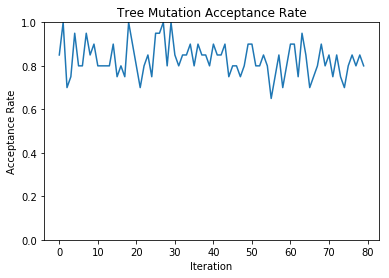

In [6]:
fig, ax = plt.subplots(1, 1)

ax.plot([x["Tree"] for x in model.acceptance_trace])
ax.set_title("Tree Mutation Acceptance Rate")
ax.set_xlabel("Iteration")
ax.set_ylabel("Acceptance Rate")
ax.set_ylim((0, 1))

# Sklearn API

Feature selection can be done in BartPy using the Sklearn selector API.  This allows for deep integration with the Sklearn pipelines

### Proportion Threshold

The simplest way to select features is to set a threshold on how often a variable is used in splits in the model trees.  The more times a tree appears in the model, the more likely it is that the feature is important and captures a meaningful pattern.

While this method is simple, the downside is that it is hard to set the threshold appropriately.  Cross validation is recommended

In [7]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=20, store_in_sample_predictions=False)
pipeline = make_pipeline(SelectSplitProportionThreshold(model, 0.3), model)
pipeline_model = pipeline.fit(X, y)

In [8]:
print("Feature Proportions", pipeline_model.named_steps["selectsplitproportionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectsplitproportionthreshold"]._get_support_mask())

Feature Proportions {0: 0.5262965668371073, 1: 0.18151935719503287}
Is Kept [ True False]


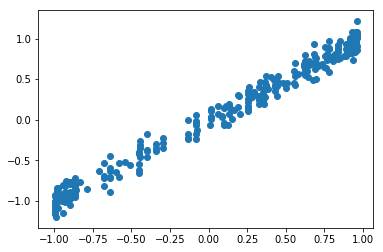

In [9]:
plt.scatter(model.predict(X), y)

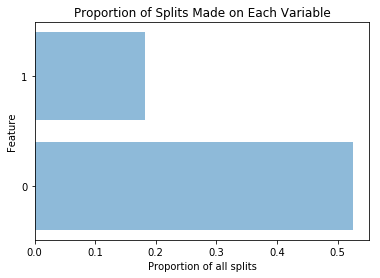

In [10]:
pipeline_model.named_steps["selectsplitproportionthreshold"].plot()

### Null Distribution Threshold

For a more principled analysis, BartPy implements the method described in https://repository.upenn.edu/cgi/viewcontent.cgi?article=1555&context=statistics_papers.

This is significantly more computationally expensive, but offers a principled way to set proportions

In [13]:
model = SklearnModel(n_samples=500, n_burn=200, n_trees=20, store_in_sample_predictions=False, n_jobs=1)
pipeline = make_pipeline(SelectNullDistributionThreshold(model, 0.9, "local"), model)
pipeline_model = pipeline.fit(X, y)

Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.75it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 88.99it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 94.25it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 98.32it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.35it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.99it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.81it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 106.31it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.64it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.09it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.98it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.26it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.81it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 85.31it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.05it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 60.78it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.55it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 129.24it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.15it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.03it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.79it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 132.26it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 133.53it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 125.03it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.81it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 136.61it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 124.34it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 126.76it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 129.24it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.84it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.44it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.16it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 127.59it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 125.87it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.05it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 104.53it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 68.69it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.41it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.42it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 134.72it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.91it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 141.93it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 141.72it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 134.96it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.74it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 140.01it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.30it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.25it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 142.69it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 136.86it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.88it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 95.91it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 134.87it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 135.27it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.75it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 133.09it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.09it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 132.93it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 129.74it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 132.43it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.14it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 135.23it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 128.45it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.77it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.02it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 136.13it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.97it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 130.62it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.99it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 130.16it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.60it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 122.34it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.12it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 133.75it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.56it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 55.20it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 30.72it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 45.45it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 55.08it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 102.71it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.58it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 101.95it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 124.64it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 110.66it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.76it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.88it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 128.57it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 93.91it/s]
C:\Users\jacoltman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


Starting burn


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [11]:
import numpy as np
np.array([1, 2, 3,4]).reshape(2, 2)[:,]

array([[1, 2],
       [3, 4]])

In [ ]:
print("Thresholds", pipeline_model.named_steps["selectnulldistributionthreshold"].thresholds)
print("Feature Proportions", pipeline_model.named_steps["selectnulldistributionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectnulldistributionthreshold"]._get_support_mask())

In [ ]:
plt.scatter(model.predict(X), y)

In [ ]:
plt.scatter(X[:,0], model.predict(X))
plt.scatter(X[:,1], model.predict(X))

In [ ]:
pipeline_model.named_steps["selectnulldistributionthreshold"].plot()

# Feature Selection

The approach so far is useful - but it doesn't give a complete picture of the importance of a single variable.  There are at least two big limitations:
1. % of splits doesn't give up an idea of how much a variable is improving accuracy
2. In cases of high correlation, the model might be able to as easily split on different variables

To get a more direct account of a single variable, we can instead permute that variable, and see how the out of sample RMSE changes.  The bigger the increase in RMSE that scrambling a variable, the more important the variable is.

([1.2875442589640158, 1.5349302151957973],
 [8.694809737061329,
  8.520081849762558,
  8.60005007961278,
  8.926416162399375,
  9.027468430662955,
  8.561770647642888,
  8.727273573769576,
  8.557241867849276,
  8.967567197121092,
  8.567056560102573,
  8.73193296923612,
  8.7067502135217,
  8.972313254229007,
  8.35214212700273,
  8.651288046527648,
  8.724776385402956,
  8.567256962305356,
  8.73687581985247,
  9.05547752801785,
  8.725922157383227])

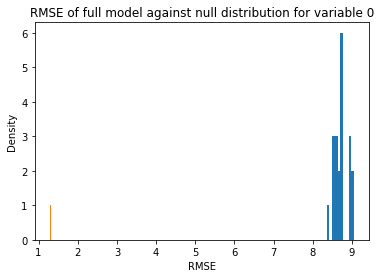

In [51]:
feature_importance(model, X, y, 0)

In [ ]:
from bartpy.diagnostics.diagnostics import plot_diagnostics
plot_diagnostics(model)